# Topic Modeling Practice

The original link was [Modeling Topic Trends in FOMC Meetings](https://highdemandskills.com/topic-trends-fomc/)

Stepping through the code:
Import libraries

We’ll need libraries for requesting and parsing minutes transcripts from the FOMC website (requests and BeautifulSoup), text pre-processing (regular expressions and SpaCy), analyzing and displaying results (pandas, numpy, wordcloud and matplotlib) and LDA modeling (gensim).

Note:  To install `spacy` and load('en_core_web_lg') you need to run the command: `python -m spacy download en_core_web_lg`


In [97]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000 # In case max_length is set to lower than this (ensure sufficient memory)

## Setting up the corpus

The corpus is the collection of FOMC meeting transcripts that we’re analyzing. It’s also used for training our LDA model.

There are a number of steps in setting up the corpus:

* Text pre-processing — we clean the transcripts by removing special characters, extra spaces, stop words and punctuation, then lemmatizing and selecting the parts-of-speech that we wish to retain (nouns, adjectives and verbs) (see this description to learn more about text pre-processing in natural language workflows)
* Extract paragraphs from each of the transcripts — analysis by paragraph lends to better LDA analysis, but we ignore small paragraphs as they don’t add much value (I use a variable called minparalength to set the minimum length of paragraph extracted)
* Set up lists — containing (i) the paragraphs from all the FOMC minutes (FOMCMinutes) as a ‘list of lists’, where each sub-list is a paragraph — this is a format suitable for input into the LDA model, (ii) a single list of all the paragraphs (FOMCWordCloud), ie. not a ‘list of lists’, which is used for generating a word cloud of the corpus, and (iii) a list containing the date and ‘weight’ of each paragraph in the corpus (FOMCTopix) — this is needed to aggregate the topic mixes of each paragraph into a combined topic mix for each meeting (see later).

To calculate the weight of each paragraph, I first calculate the total number of characters in each minutes transcript and store this in a variable called `cum_paras`. Then, for each paragraph I calculate the paragraph’s length (number of characters len(para)) and divide it by `cum_paras` to arrive at the weight for that paragraph in the minutes transcript. I store the result in FOMCTopix.

Note that the total weights of all paragraphs in a given minutes transcript will sum to 1.

To set up the corpus, I define a function called PrepareCorpus which steps through each of the minutes transcripts, sources it and applies the above steps.

In [98]:
FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para

import pandas as pd

# Define function to prepare corpus
def PrepareCorpus(fomc_statements_file ,  minparalength, numdocs):

    fomcstatements = []
    fomcwordcloud = []
    fomctopix = []
    
    df_fomc_statements_raw = pd.read_csv( fomc_statements_file )
    
    df_fomc_statements = df_fomc_statements_raw[ :numdocs]
    
    for statement in df_fomc_statements.text:
        
        #print("\n Raw statement\n")
        #print(statement[:150])
        
        # Clean text - stage 1
        statement = statement.strip()  # Remove white space at the beginning and end
        statement = statement.replace('\r', '') # Replace the \r with null
        statement = statement.replace(' ', ' ') # Replace " " with space. 
        statement = statement.replace(' ', ' ') # Replace " " with space.
        
        while '  ' in statement:
            statement = statement.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)    
        statement = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', statement) # Replace with null

        
        #print("\n Stage 2\n")
        #print( statement)
        
        # Find length of minutes document for calculating paragraph weights
        statementParas = statement.split('\n') # List of paras in statement, where statement is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given  transcript
        for para in statementParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)
        
        # Extract paragraphs
        for para in statementParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'
                
                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(statement) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text
                            
                # Parse cleaned para with SpaCy
                statementPara = nlp(para)
                
                statementTmp = [] # Temporary list to store individual tokens
                
                # Further cleaning and selection of text characteristics
                for token in statementPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB"): # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        statementTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcstatements.append(statementTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing
            
    return fomcstatements, fomcwordcloud, fomctopix

We can now call the above function to prepare our corpus.

In [99]:
# Prepare corpus
derived_data_dir = "../derived"

fomc_statements_file = derived_data_dir + "/" + "FOMC_statements.csv"

FOMCStatements, FOMCWordCloud, FOMCTopix = PrepareCorpus( fomc_statements_file , minparalength=10, numdocs = 1)


I set minparalength to 10 — this seems to be a good length for capturing paragraphs which have meaningful content. Shorter paragraphs tend to contain greetings or administrative comments.

In [101]:
FOMCTopix

[['The Federal Open Market Committee decided today to keep its target for the federal funds rate at 5-1/4 percent. Recent indicators have suggested somewhat firmer economic growth, and some tentative signs of stabilization have appeared in the housing market. Overall, the economy seems likely to expand at a moderate pace over coming quarters. Readings on core inflation have improved modestly in recent months, and inflation pressures seem likely to moderate over time. However, the high level of resource utilization has the potential to sustain inflation pressures. The Committee judges that some inflation risks remain. The extent and timing of any additional firming that may be needed to address these risks will depend on the evolution of the outlook for both inflation and economic growth, as implied by incoming information. Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Susan S. Bies; Thomas M. Hoenig; Donald L. Kohn; Rand

# Inspecting the corpus

We can see what the prepared corpus looks like by generating a word cloud.

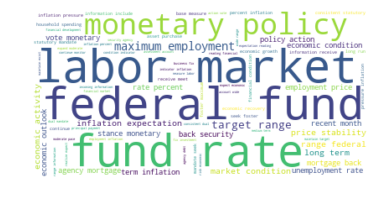

In [87]:
# Generate and plot WordCloud for full corpus
wordcloud = WordCloud(background_color="white").generate(','.join(FOMCWordCloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We see a number of words in the corpus that are typical of FOMC meetings, including “federal”, “fund rate”, “market” and “labor market”.

# Training the LDA model

To train our LDA model, we first need to form a dictionary from our corpus. We map the corpus to word IDs, then convert the words using a bag-of-words approach and finally apply TF-IDF to the result. This process is called text representation.



In [88]:
# Form dictionary by mapping word IDs to words
ID2word = corpora.Dictionary(FOMCStatements)

# Set up Bag of Words and TFIDF
corpus = [ID2word.doc2bow(doc) for doc in FOMCStatements] # Apply Bag of Words to all documents in corpus
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus] # Apply TF-IDF model


We use TF-IDF as it produces better results than using bag-of-words alone. TF-IDF adjusts for words that appear frequently but have low semantic value, relative to words that appear infrequently but with higher semantic value. This favors words which have more meaning in the context of the corpus.

We next select the model parameters that we wish to use and run the model.



In [89]:
SEED = 130 # Set random seed
NUM_topics = 5 # Set number of topics
ALPHA = 0.15 # Set alpha
ETA = 1.25 # Set eta

# Train LDA model using the corpus
lda_model = gensim.models.LdaMulticore(corpus=trans_TFIDF, 
                                       num_topics=NUM_topics, 
                                       id2word=ID2word, 
                                       random_state=SEED, 
                                       alpha=ALPHA, eta=ETA, 
                                       passes=200)

The parameters shown above are key inputs for an LDA model. NUM_topics, in particular, needs to be set by the user. The other parameters (SEED, ALPHA and ETA) help to produce better results with fine-tuning.

To learn more about LDA parameters and the process for fine-tuning them, 
please see this description of LDA model evaluation.  
(https://highdemandskills.com/topic-modeling-lda/#h3-3)

(https://highdemandskills.com/topic-model-evaluation/)

How do we evaluate the results of our LDA model?

There are quantitative approaches for doing this, but when applied to a text corpus it’s helpful to produce results that have a sensible human interpretation. This requires judgement.

In terms of quantitative measures, a common measure for evaluating LDA models is the *coherence score*. This measures the semantic similarity (likeness of meaning) between the words in each topic of an LDA model. All else equal, a higher coherence score is better.

We can measure the coherence of our model using the CoherenceModel in gensim.



In [90]:
# Set up coherence model
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=FOMCStatements, dictionary=ID2word, coherence='c_v')

# Calculate coherence
coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.4975553528826304


This is a fairly good result, based on careful selection of the above parameters.

How did we arrive at our parameters?

In choosing the number of topics (NUM_topics), I was guided by Jegadeesh and Wu, who choose 8 topics for their LDA model — I chose the same, as it tended to produce sensible topic interpretations.

To select the other parameters, you can explore the effect of changing parameter values on model coherence— refer the section TEST COHERENCE BY VARYING KEY PARAMETERS in the full code listing.

A test of coherence by varying alpha, for instance, results in the following plot (refer full code listing):
LDA model coherence by varying alpha

The above plot suggests that an alpha of 0.15 produces a high coherence — this is the value of alpha adopted.

Note that by setting the SEED parameter, we ensure that the model will produce the same results with repeated runs.

# Analyzing the topic mix

Since we’re using the same corpus for training and analysis, we don’t need to run the trained LDA model on a new set of documents. Instead, we can go straight to analyzing the corpus.

Our goal is to calculate the topic mix for each of the minutes transcripts in the corpus. By plotting the topic mix over the chronological sequence of the meetings (since each meeting occurred on a given date), we can observe any trends or changes in the topic mix over time.

Recall that we divided our corpus into individual paragraphs, hence our model will produce a topic mix for each paragraph of each transcript in the corpus. The topic mix is a proportionate allocation to each of the (NUM_topics) topics in the model for each paragraph. The proportions across all topics in the paragraph will sum to 1.

We now need to convert these paragraph-level topic mixes to document-level topic mixes (ie. to create an aggregate topic mix for each meeting).

Once again I was guided by Jegadeesh and Wu. They calculate document-level topic mixes (each document being a minutes transcript in our case) using a weighted sum of paragraph-level topic mixes — I adopt the same approach.

We’ve already calculated each paragraph’s weight when we set up our corpus and stored it in FOMCTopix. Let’s call these weights the ‘document-weight’ of each paragraph. Using this, we generate aggregate topic mixes as follows:

    Extract the topic mix for each paragraph and store the result in FOMCTopix alongside the paragraph’s meeting date and its document-weight
    Multiply each topic proportion in the paragraph’s topic mix by the paragraph’s document-weight
    For each document (ie. individual meeting transcript), sum the topic proportions, topic by topic, across all topics for all paragraphs in the transcript

We will end up with the weighted topic mixes for each minutes transcript, where the weights are based on the relative lengths of the paragraphs within each transcript.

I extract each paragraph’s topic mix using the get_document_topics method of gensim and append the results to FOMCTopix, which is in a list format. I then convert this list to a data frame object and call the pivot_table method to sum the topic proportions across all paragraphs within each minutes transcript.

In [91]:
para_no = 0 # Set document counter
for para in FOMCTopix:
    TFIDF_para = TFIDF[corpus[para_no]] # Apply TFIDF model to individual minutes documents
    # Generate and store weighted topic proportions for each para
    for topic_weight in lda_model.get_document_topics(TFIDF_para): # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
        FOMCTopix[para_no].append(FOMCTopix[para_no][1]*topic_weight[1]) # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
    para_no += 1

# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(FOMCTopix, columns=['Date', 'Weight', 'Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'])

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=['Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'], index='Date', aggfunc=np.sum)


ValueError: 10 columns passed, passed data had 7 columns

Note that I have assigned names to some of the topics in the above code — I’ll discuss this in the next section.

## Interpreting topics

Although LDA topic modeling is a quantitative process, the identified topics may not always lend themselves to easy interpretation. You can apply judgment in how you label and select topics depending on your analysis.

You can explore topic contents by generating word clouds.



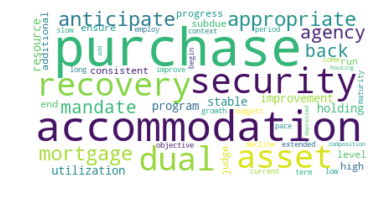

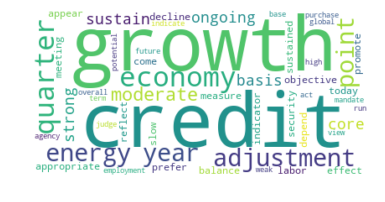

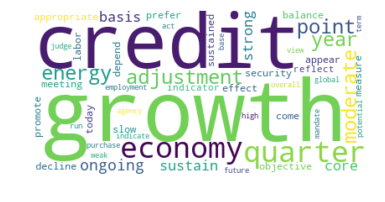

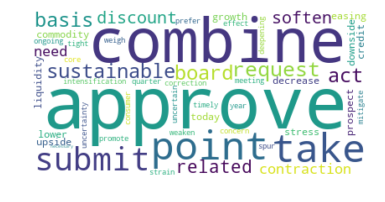

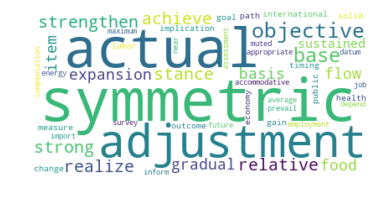

In [75]:
topic = 0 # Initialize counter
while topic < NUM_topics:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic += 1
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [68]:
# Plot results - select which topics to print
TopixAggDF.plot(y=['Inflation', 'Consumption', 'Market', 'Policy'], kind='line', use_index=True)

KeyError: "None of [Index(['Inflation', 'Consumption', 'Market', 'Policy'], dtype='object')] are in the [columns]"

In [76]:
TopixAggDF

""
Date


In [80]:
topics = lda_model.show_topics(num_topics=NUM_topics, num_words=8, formatted=False)
topics = sorted(topics, key=lambda x: int(x[0]))
print("Num topics {}".format(len(topics)))

Num topics 5


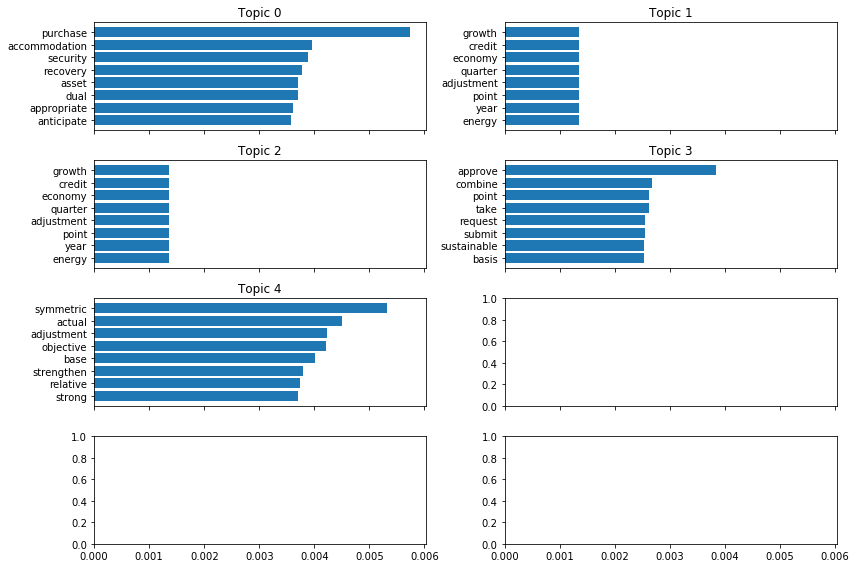

In [84]:
rows = 4
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 8))

for topic_id, word_props in topics:
    row = topic_id // cols
    col = topic_id - (row * cols)
    
    ax = axs[row, col]
    words, probs = zip(*word_props)
    ax.barh(words, probs)
    ax.invert_yaxis()
    ax.set_title('Topic {}'.format(topic_id))

plt.tight_layout()
plt.show()

In [96]:
lda_model.show_topics( FOMCStatements[1])

TypeError: '<' not supported between instances of 'list' and 'int'